## Import libraries

In [17]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.stats import poisson, nbinom

## Load data - exports

In [18]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

In [19]:
df = pd.read_csv(data_path / 'dati_leo_assoluti.csv')
df = df.reset_index(drop=True)

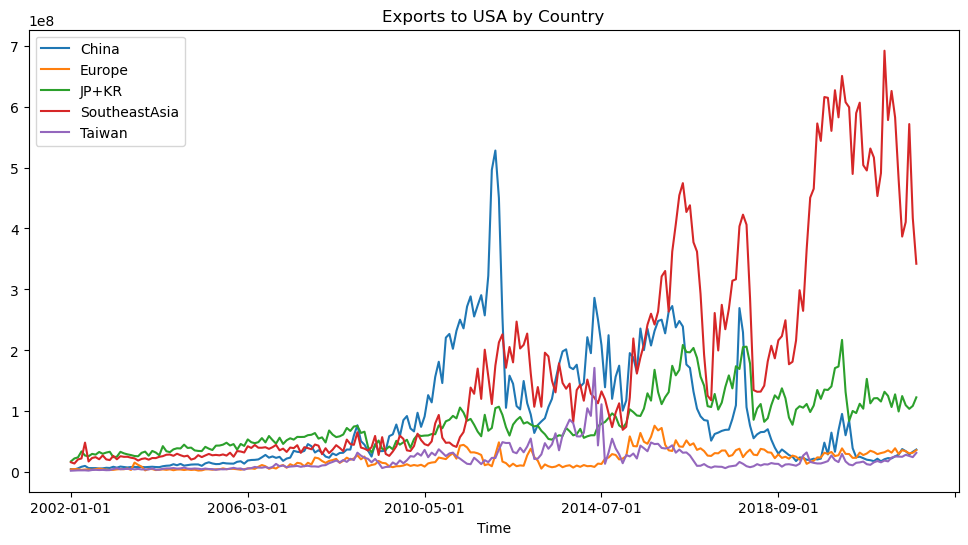

In [20]:
df.set_index('Time').plot(figsize=(12, 6), title='Exports to USA by Country')
plt.show()

## Model

In [22]:
# Uncomment if you want normalized values
df_normalized = pd.read_csv(data_path / 'dati_leo_normalizzati.csv')
df_normalized = df_normalized.reset_index(drop=True)
df_normalized = df_normalized.drop(columns=['Europe', 'total'])
df_normalized

# # Uncomment if you want absolute values
# df_normalized = df.copy()
# df_normalized = df_normalized.drop(columns=['Europe'])
# df_normalized

,Time,China,JP+KR,SoutheastAsia,Taiwan
0,2002-01-01,0.110311,0.380993,0.352239,0.054684
1,2002-02-01,0.093534,0.454315,0.287546,0.057884
2,2002-03-01,0.107718,0.406185,0.349512,0.052608
3,2002-04-01,0.123506,0.467669,0.310324,0.044436
4,2002-05-01,0.110933,0.290828,0.515878,0.033958
...,...,...,...,...,...
235,2021-08-01,0.062298,0.204443,0.632360,0.041596
236,2021-09-01,0.055998,0.177974,0.663774,0.046366
237,2021-10-01,0.038418,0.136539,0.749306,0.035138
238,2021-11-01,0.054520,0.176605,0.676466,0.040333


In [23]:
df_tariffs = pd.DataFrame()
df_tariffs['Time'] = df_normalized['Time']
df_tariffs

,Time
0,2002-01-01
1,2002-02-01
2,2002-03-01
3,2002-04-01
4,2002-05-01
...,...
235,2021-08-01
236,2021-09-01
237,2021-10-01
238,2021-11-01


In [24]:
df_tariffs['China Tariff'] = np.where(df_tariffs['Time'] < '2012-05-01', 0, 1)
df_tariffs['JP+KR Tariff'] = np.where(df_tariffs['Time'] < '2018-02-01', 0, 1)
df_tariffs['SoutheastAsia Tariff'] = np.where(df_tariffs['Time'] < '2018-02-01', 0, 1)
df_tariffs['Taiwan Tariff'] = np.where(df_tariffs['Time'] < '2014-12-01', 0, 1)
df_tariffs

,Time,China Tariff,JP+KR Tariff,SoutheastAsia Tariff,Taiwan Tariff
0,2002-01-01,0,0,0,0
1,2002-02-01,0,0,0,0
2,2002-03-01,0,0,0,0
3,2002-04-01,0,0,0,0
4,2002-05-01,0,0,0,0
...,...,...,...,...,...
235,2021-08-01,1,1,1,1
236,2021-09-01,1,1,1,1
237,2021-10-01,1,1,1,1
238,2021-11-01,1,1,1,1


In [25]:
def lotka_volterra_with_tariffs_end(t, X, tariffs,
                                r1, r2, r3, r4,
                                a11, a12, a13, a14,
                                a21, a22, a23, a24,
                                a31, a32, a33, a34,
                                a41, a42, a43, a44,
                                b11, b12, b13, b14,
                                b21, b22, b23, b24,
                                b31, b32, b33, b34,
                                b41, b42, b43, b44):
    X1, X2, X3, X4 = X
    tariff_1, tariff_2, tariff_3, tariff_4 = tariffs.iloc[int(t), 1:]

    dx1dt = r1 * X1 * (1 - a11*X1 - a12*X2 - a13*X3 - a14*X4) - b11 * X2 * X3 * X4 * tariff_1 + b12 * X2 * tariff_2 + b13 * X3 * tariff_3 + b14 * X4 * tariff_4
    dx2dt = r2 * X2 * (1 - a21*X1 - a22*X2 - a23*X3 - a24*X4) + b21 * X1 * tariff_1 - b22 * X1 * X3 * X4 * tariff_2 + b23 * X3 * tariff_3 + b24 * X4 * tariff_4
    dx3dt = r3 * X3 * (1 - a31*X1 - a32*X2 - a33*X3 - a34*X4) + b31 * X1 * tariff_1 + b32 * X2 * tariff_2 - b33 * X1 * X2 * X4 * tariff_3 + b34 * X4 * tariff_4
    dx4dt = r4 * X4 * (1 - a41*X1 - a42*X2 - a43*X3 - a44*X4) + b41 * X1 * tariff_1 + b42 * X2 * tariff_2 + b43 * X3 * tariff_3 - b44 * X1 * X2 * X3 * tariff_4

    return [dx1dt, dx2dt, dx3dt, dx4dt]

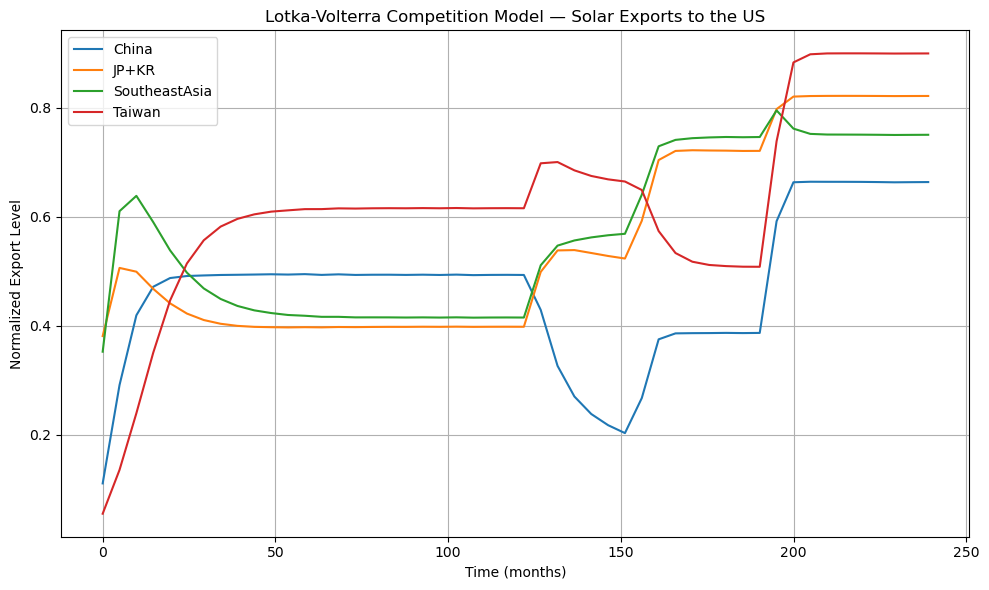

In [ ]:
# Uncomment to use parameters for normalized values
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.35,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.5,
    'a41': 0.2, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0,
    'b11': 0.1, 'b12': 0.1, 'b13': 0.1, 'b14': 0.1,
    'b21': 0.1, 'b22': 0.1, 'b23': 0.1, 'b24': 0.1,
    'b31': 0.1, 'b32': 0.1, 'b33': 0.1, 'b34': 0.1,
    'b41': 0.1, 'b42': 0.1, 'b43': 0.1, 'b44': 0.1
}

# # Uncomment to use parameters for absolute values
# params = {
#     'r1': 50.0, 'r2': 30.0, 'r3': 40.0, 'r4': 35.0,
#     'a11': 0.00001, 'a12': 0.000006, 'a13': 0.000004, 'a14': 0.000003,
#     'a21': 0.000004, 'a22': 0.000002, 'a23': 0.000003, 'a24': 0.000004,
#     'a31': 0.000004, 'a32': 0.000002, 'a33': 0.000003, 'a34': 0.000005,
#     'a41': 0.000006, 'a42': 0.000004, 'a43': 0.000004, 'a44': 0.00001,
#     'b11': 0.000001, 'b21': 0.000001, 'b31': 0.000001, 'b41': 0.000001,
#     'b12': 0.000001, 'b22': 0.000001, 'b32': 0.000001, 'b42': 0.000001,
#     'b13': 0.000001, 'b23': 0.000001, 'b33': 0.000001, 'b43': 0.000001,
#     'b14': 0.000001, 'b24': 0.000001, 'b34': 0.000001, 'b44': 0.000001
# }


# Initial conditions (example, adjust as needed)
X0 = df_normalized.iloc[0, 1:].values.tolist()  # Use the first row of normalized data as initial conditions

# Time span and evaluation points
t_span = (0, 239)
t_eval = np.linspace(*t_span)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='JP+KR')
plt.plot(sol.t, sol.y[2], label='SoutheastAsia')
plt.plot(sol.t, sol.y[3], label='Taiwan')
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Calibration - Least Squares

In [27]:
china_data = df_normalized['China']
jpkr_data = df_normalized['JP+KR']
southeastasia_data = df_normalized['SoutheastAsia']
taiwan_data = df_normalized['Taiwan']

# Stack data for comparison
data = np.vstack([china_data, jpkr_data, southeastasia_data, taiwan_data])  # shape (4, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [28]:
def residuals(params, X0, tariffs, t_data, data):
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:20]
    b11, b12, b13, b14 = params[20:24]
    b21, b22, b23, b24 = params[24:28]
    b31, b32, b33, b34 = params[28:32]
    b41, b42, b43, b44 = params[32:36]

    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_with_tariffs_end(
            t, X, tariffs, r1, r2, r3, r4,
            a11, a12, a13, a14,
            a21, a22, a23, a24,
            a31, a32, a33, a34,
            a41, a42, a43, a44,
            b11, b12, b13, b14,
            b21, b22, b23, b24,
            b31, b32, b33, b34,
            b41, b42, b43, b44
        ),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    return (sol.y - data).ravel()

In [29]:
# Initial guess for 4 regions: r1, r2, r3, r4, a11, a12, a13, a14, ..., b44 (total 36 params)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,   # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.3,    # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.4,    # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.5,    # a31, a32, a33, a34
    0.2, 0.3, 0.4, 1.0,    # a41, a42, a43, a44
    0.1, 0.1, 0.1, 0.1,     # b11, b12, b13, b14
    0.1, 0.1, 0.1, 0.1,     # b21, b22, b23, b24
    0.1, 0.1, 0.1, 0.1,     # b31, b32, b33, b34
    0.1, 0.1, 0.1, 0.1      # b41, b42, b43, b44
]

# Initial export levels from your data
X0 = data[:, 0]

# Fit the model
result = least_squares(residuals, initial_guess, args=(X0, df_tariffs, t_data, data),
                       bounds=(0, 2))  # constrain params to be positive

# Extract best-fit parameters
fitted_params = result.x

In [30]:
fitted_params

array([7.00992170e-01, 4.54147773e-01, 2.59431277e-01, 8.41281741e-01,
       1.25344995e+00, 1.24535209e+00, 1.00979323e+00, 6.43307453e-02,
       4.14988226e-01, 1.36769083e+00, 1.09262109e+00, 1.99547390e+00,
       7.27283783e-01, 7.60657208e-01, 1.77877669e+00, 1.27000925e+00,
       4.44093292e-01, 1.14480552e+00, 1.36967048e+00, 1.62293342e+00,
       2.00129339e-01, 1.91118181e-02, 5.19152164e-03, 1.00137896e-02,
       2.64184837e-02, 9.99847189e-01, 3.23532148e-02, 6.53061514e-04,
       5.47057026e-02, 3.52660708e-01, 6.40835188e-02, 1.62840000e-01,
       4.75853687e-02, 2.26898481e-02, 1.92197079e-02, 4.06161214e-01])

In [31]:
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_with_tariffs_end(t, X, df_tariffs, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

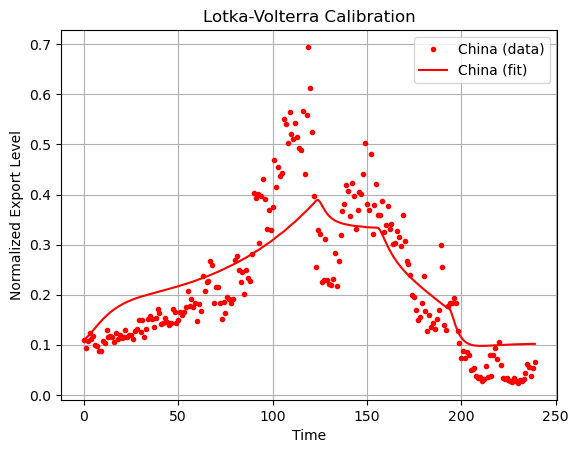

In [32]:
# Plot
plt.plot(t_data[:len(data[0])], data[0], 'r.', label='China (data)')
plt.plot(t_data, sol.y[0], 'r-', label='China (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

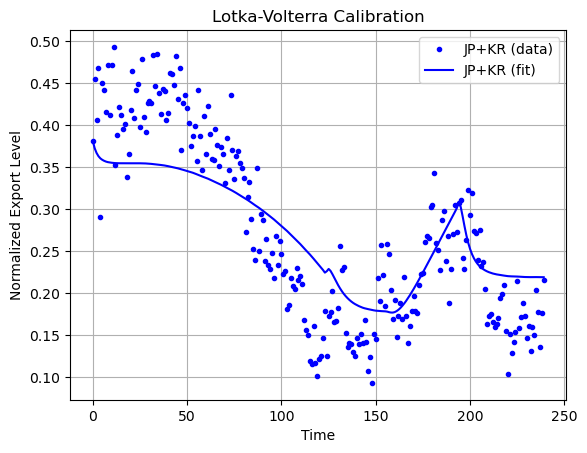

In [33]:
plt.plot(t_data[:len(data[1])], data[1], 'b.', label='JP+KR (data)')
plt.plot(t_data, sol.y[1], 'b-', label='JP+KR (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

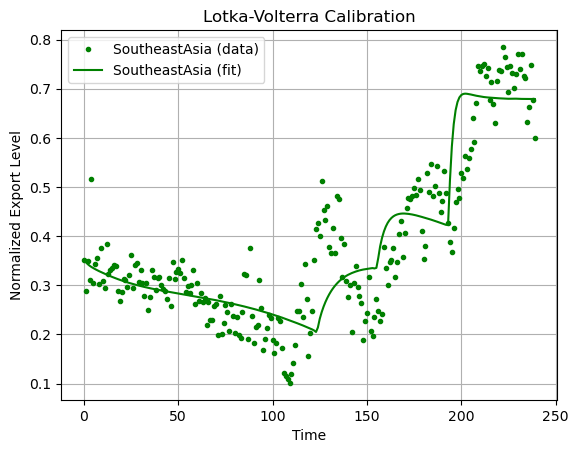

In [34]:
plt.plot(t_data[:len(data[2])], data[2], 'g.', label='SoutheastAsia (data)')
plt.plot(t_data, sol.y[2], 'g-', label='SoutheastAsia (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()

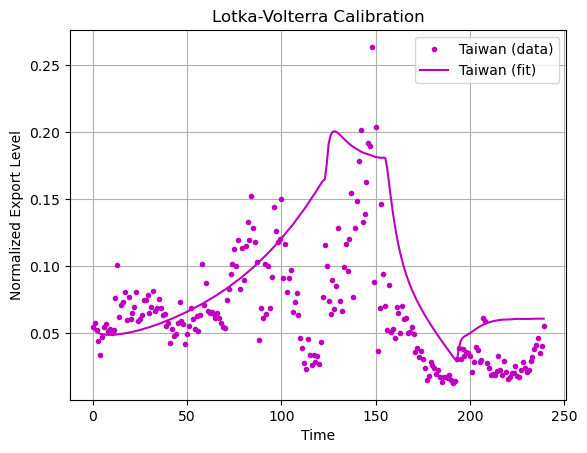

In [35]:
plt.plot(t_data[:len(data[3])], data[3], 'm.', label='Taiwan (data)')
plt.plot(t_data, sol.y[3], 'm-', label='Taiwan (fit)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration')
plt.grid(True)
plt.show()